In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")

In [10]:

class SpectralClusteringKVV:
    def __init__(self, sigma_I, sigma_X, r, lanczos_k, l, cheeger_conduntance = None, max_clusters = None):
        self.sigma_I = sigma_I #intsnsitiy scale
        self.sigma_X = sigma_X #spatial sclae
        self.r = r # spatial cutoff
        self.lanczos_k = lanczos_k
        self.l = l
        self.cheeger_conduntance = cheeger_conduntance  # threshold za splitting
        self.current_cluster_id = 0
        self.max_clusters = max_clusters

    #-----------------------učitavanje slike-----------------------------
    def load_image(self, image_path):
        self.img = io.imread(image_path, as_gray=True).astype(np.float64)
        # skaliranje brigthnessa na 0-255
        self.img *= 255  
        self.img = np.clip(self.img, 0, 255)
        self.rows, self.cols = self.img.shape
        #------------------pretvaranje pixela u čvorove------------------
        self.X = np.array([(i, j) for i in range(self.rows) for j in range(self.cols)])
        self.intensities = self.img.flatten()
        self.n = self.X.shape[0]
        self.clusters = np.zeros(self.n, dtype=int) # ???
        return self
    
    """ 1.KORAK """
    #---------------------- iz rada SM formula za simm.----------------------
    def compute_similarity_matrix(self):
        W = np.zeros((self.n, self.n))  # simmilarity matrix prema brightness
        r_sq = self.r ** 2
        for i in range(self.n):
                for j in range(i + 1, self.n):
                    spatial_dist_sq = np.linalg.norm(self.X[i] - self.X[j])
                    if spatial_dist_sq < r_sq:
                        intensity_diff_sq = np.linalg.norm(self.intensities[i] - self.intensities[j]) ** 2
                        w_ij = np.exp(-intensity_diff_sq / (self.sigma_I ** 2)) * \
                            np.exp(-spatial_dist_sq**2 / (self.sigma_X ** 2))
                        W[i, j] = w_ij
                        W[j, i] = w_ij

            
        self.W = W
        return self

    """ 2.KORAK """
    #---------------------- eigenvrijednosti - eigenvektori ----------------
    def compute_laplacian(self, W=None):
        #L = D - W -> nenormalizirana matrica
        if W is None:
            W = self.W
        D = np.diag(np.sum(W, axis=1))
        # PROBLEM: nekad naiđe na dijeljenje s 0
        # 
        D_inv_sqrt = np.diag([1.0 / np.sqrt(d) if d != 0 else 0 for d in np.diag(D)]) # D^1/2
        return D_inv_sqrt @ (D - W) @ D_inv_sqrt

    

    def compute_fiedler_vector(self, L):
        #b = np.random.rand(self.n)
        b = np.ones(L.shape[0]) # da maknemo randomness
        eigvals, eigvecs = np.linalg.eigh(L)
        fiedler = L @ eigvecs[:, 1]
        fiedler = np.sign(fiedler[np.argmax(np.abs(fiedler))]) * fiedler # consistent sign ??
        return fiedler

    """ 3.KORAK """
    #----------------------------- N-cut ----------------------------------
    # "Currently, the search is done by checking l evenly spaced possible 
    # splitting points, and computing the best Ncut among them.""
    #clusters = np.where(fiedler_vector >= 0, 1, 0)  # separacija prema predznaku
    def compute_cheeger_conduntance(self, W, D, C, CC):
        degrees = np.sum(W, axis=1)
        cut = np.sum(W[np.ix_(C, CC)])
        vol_C = np.sum(degrees[C])
        vol_not_C = np.sum(degrees[CC])
        return cut / min(vol_C, vol_not_C)

    
    
    def recursive_two_way(self, indices, parent_cluster_id=0):
        # logika da se i prati max broj grupa: or self.current_cluster_id >= self.max_clusters - 1
        if len(indices) < self.l :
            self.clusters[indices] = parent_cluster_id
            return

        # podgrafovi za trenutni cluser
        # ne računam ponovno nego uzimam manje iz originalnog
        W_sub = self.W[indices][:, indices]
        # kvv-sum
        """  row_sums = np.sum(W_sub, axis=1, keepdims=True)
        W_sub = W_sub / row_sums """
        # kvv-add
        row_sums = np.sum(W_sub, axis=1)
        for i in range(len(W_sub)):
            diff = 1.0 - row_sums[i]
            if diff > 0:
                W_sub[i, i] += diff
        L_sub = self.compute_laplacian(W_sub)
        
        fiedler = self.compute_fiedler_vector(L_sub)
        
        #------------------------ Find optimal split ----------------------------
        sorted_idx = np.argsort(fiedler)
        min_cheeger_values = np.inf
        best_split = self.l
        for i in range(self.l, len(fiedler) - self.l, self.l):
            C = sorted_idx[:i]
            CC = sorted_idx[i:]
            current_cheeger = self.compute_cheeger_conduntance(W_sub, np.diag(np.sum(W_sub, axis=1)), C, CC)
            if current_cheeger < min_cheeger_values:
                min_cheeger_values = current_cheeger
                best_split = i
        "4. KORAK "
        #----------------------------- cut - stability ----------------------------
        # kako odrediti max cut:
            # empririjski [0.1,0.5] ->provjeriti
            # malo iznad prosjeka
        #self.max_ncut = np.mean(ncut_values) # previše grupa
        
        # dijeliti ili ne
        # logika da se prati  i broj grupa: """ and self.current_cluster_id < self.max_clusters - 1 """
        """if  min_cheeger_values < self.cheeger_conduntance:   """
        if self.current_cluster_id < self.max_clusters - 1:
            left = indices[sorted_idx[:best_split]]
            right = indices[sorted_idx[best_split:]]
            
            "5. KORAK"
            #----------------------------- two-way recursion ----------------------------
            self.current_cluster_id += 1
            new_cluster_id = self.current_cluster_id
            
            self.clusters[right] = new_cluster_id
            self.recursive_two_way(left, parent_cluster_id)
            self.recursive_two_way(right, new_cluster_id)
        else:
            self.clusters[indices] = parent_cluster_id
            
       

    # pipline koji poziva sve bitne funkcije
    def segment_image(self):
        self.compute_similarity_matrix()
        self.recursive_two_way(np.arange(self.n))
        return self.clusters.reshape((self.rows, self.cols))
    
    #---------------------------------- average color ---------------------------------------
    def average_color(self):
        self.segmented_img = self.clusters.reshape((self.rows, self.cols))
        num_clusters = len(set(self.clusters))
        group_sums = np.zeros(num_clusters)
        group_counts = np.zeros(num_clusters)

        for i in range(self.segmented_img.shape[0]):
            for j in range(self.segmented_img.shape[1]):
                group_label = self.segmented_img[i, j]
                group_value = self.img[i, j]
                
                group_sums[group_label] += group_value
                group_counts[group_label] += 1

        group_averages = (group_sums / group_counts) / 255
        rgb_grouped = [(group_averages[i], group_averages[i], group_averages[i]) for i in range(0, len(group_averages))]
        cmap = mcolors.ListedColormap(rgb_grouped)
    
        return cmap
    

    def visualize(self):
        segmented_img = self.clusters.reshape((self.rows, self.cols))
        cmap_custom = self.average_color()
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(self.img, cmap='gray')
        axs[0].set_title('Original')
        axs[0].axis('off')
        
        axs[1].imshow(segmented_img, cmap=cmap_custom)
        axs[1].set_title('Spectralno Grupiranje: Ncut + Lanczos')
        axs[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        
#2d dio
    def load_2d_data(self, data_2d):
        self.X = np.array(data_2d)
        self.intensities = np.zeros(len(data_2d))  
        self.n = self.X.shape[0]
        self.rows, self.cols = 1, self.n
        self.clusters = np.zeros(self.n, dtype=int) # ???
        return self
    
    def compute_similarity_matrix_2d_gauss(self):
        W = np.zeros((self.n, self.n))
        for i in range(self.n):
            for j in range(i + 1, self.n):
                dist_sq = np.linalg.norm(self.X[i] - self.X[j]) ** 2
                w_ij = np.exp(-dist_sq / (2 * self.sigma_X ** 2))
                W[i, j] = w_ij
                W[j, i] = w_ij
        self.W = W
        return self
    
    def segment_2d(self,data):
        self.load_2d_data(data)
        self.compute_similarity_matrix_2d_gauss()
        self.recursive_two_way(np.arange(self.n))
        return self.clusters.reshape((self.rows, self.cols))

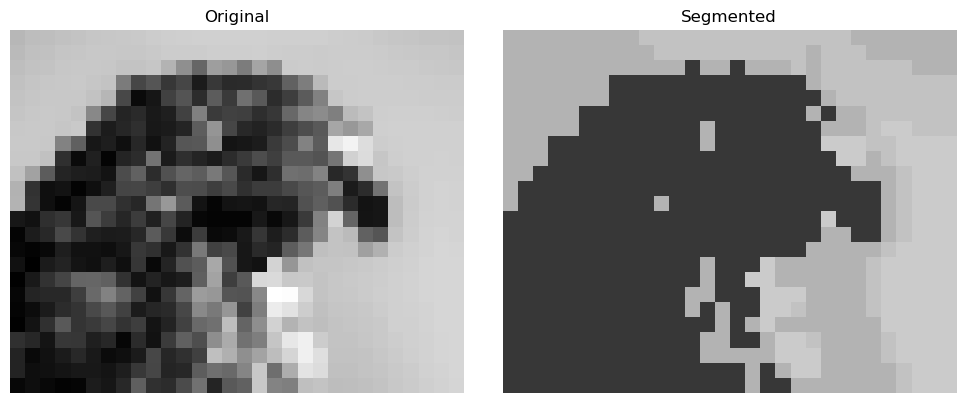

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

clusterer = SpectralClusteringKVV(sigma_I=0.1, sigma_X=5.0, r=10, lanczos_k=30, l=10)
clusterer.load_image("images/eagle_30px.png") 

axs[0].imshow(clusterer.img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

clusterer = SpectralClusteringKVV(sigma_I=50, sigma_X=100, r=10, lanczos_k=10, l=10, max_clusters= 4)
clusterer.load_image("images/eagle_30px.png")
segmented = clusterer.segment_image()

cmap_custom = clusterer.average_color()
axs[1].imshow(segmented, cmap=cmap_custom)
axs[1].set_title('Segmented')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Ncut je maximalan, tako da možemo upravljati brojem clustera, jer uvjet za grupiranje je ili dosegnut n-cut ili max_cluster
def visualize_line(image_name, values, custom):
    fig, axs = plt.subplots(1, len(values) + 1, figsize=(20, 4))

    clusterer = SpectralClusteringKVV(sigma_I=0.1, sigma_X=5.0, r=10, lanczos_k=30, l=10)
    clusterer.load_image(image_name) 

    axs[0].imshow(clusterer.img, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    for idx, n in enumerate(values):
        clusterer = SpectralClusteringKVV(sigma_I=50, sigma_X=100, r=10, lanczos_k=10, l=10, max_clusters= n)
        clusterer.load_image(image_name)
        segmented = clusterer.segment_image()
        if custom == True:
            # ------------------------------------------------------  custom set boja ----------------------------
            cmap_custom = clusterer.average_color()
            axs[idx + 1].imshow(segmented, cmap=cmap_custom)
        else:
            axs[idx + 1].imshow(segmented, cmap='gray')
        axs[idx + 1].set_title(f'Segm (n_cut={n})')
        axs[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

### Primjer s drugim slikama 

custom boje


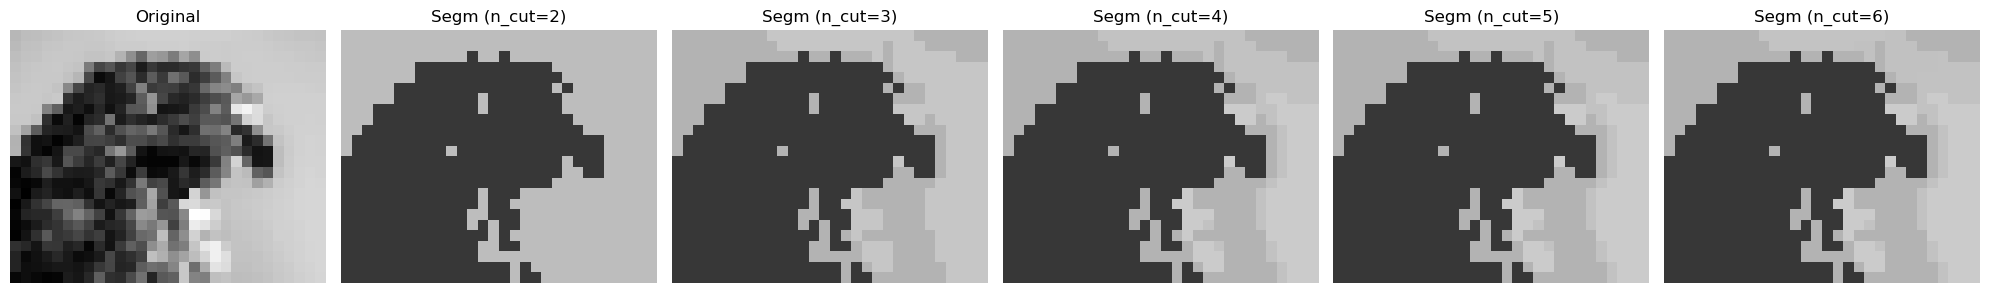

" print('random boje')\nvisualize_line('images/eagle_30px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99, 0.999], False)\n "

In [5]:
print('custom boje')
visualize_line('images/eagle_30px.png', [2,3,4,5,6], True)

""" print('random boje')
visualize_line('images/eagle_30px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99, 0.999], False)
 """
#clusteri ne idu preko 6 

#dvije varijante: 17s


In [6]:
""" print('custom boje')
visualize_line('images/cat_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  True)

print('random boje')
visualize_line('images/cat_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  False) """


" print('custom boje')\nvisualize_line('images/cat_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  True)\n\nprint('random boje')\nvisualize_line('images/cat_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  False) "

In [7]:
""" print('custom boje')
visualize_line('images/eye_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  True)

print('random boje')
visualize_line('images/eye_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  False) """

" print('custom boje')\nvisualize_line('images/eye_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  True)\n\nprint('random boje')\nvisualize_line('images/eye_40px.png', [0.1,0.7,0.9, 0.95, 9.88, 0.99,0.995, 0.999],  False) "

IRIS


In [8]:
from sklearn.datasets import load_iris

# Load the dataset
iris = load_iris()

# Features (150 samples × 4 features)
X = iris.data

# Labels (0, 1, 2 for the three iris species)
y = iris.target

# Optional: feature names
feature_names = iris.feature_names

# Optional: target names (species)
target_names = iris.target_names


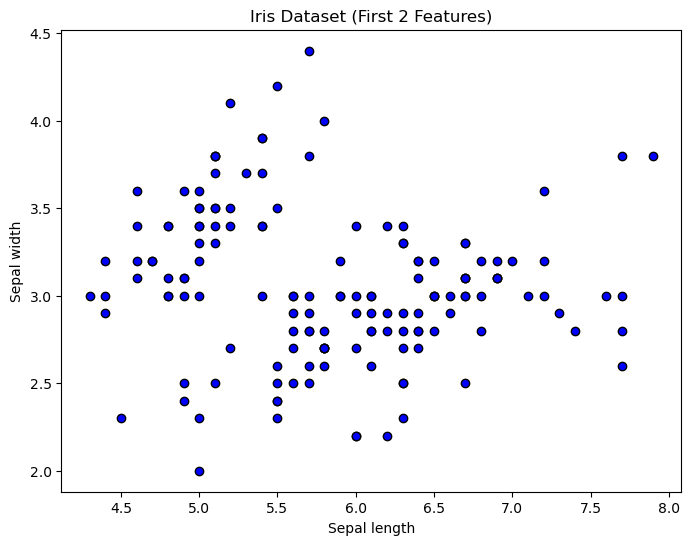

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], color='blue', edgecolor='k') 
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris Dataset (First 2 Features)')
plt.show()


In [ ]:
clusterer = SpectralClusteringSM(sigma_I=10, sigma_X=1, r=10, 
                                 lanczos_k=10, l=3, ncut_max=0.6)
labels = clusterer.segment_2d(X)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels) 
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris Dataset (First 2 Features)')
plt.show()